# Mie Theory in Python

In this notebook, we will practice using PyMieScatt to calculate the scattering properties of a sphere. We will also look at distributions of spheres.
Uncomment the code below to install the two packages we will need.

The documentation in the PyMieScatt is good, You can find it here: https://pymiescatt.readthedocs.io/en/latest/

RI database https://refractiveindex.info/

In [7]:
# !pip install shapely
# !pip install PyMieScatt

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import json as json # for printing dictionaries

import PyMieScatt as ps # the main package


In [9]:
help(np.arange)

Help on built-in function arange in module numpy:

arange(...)
    arange([start,] stop[, step,], dtype=None)
    
    Return evenly spaced values within a given interval.
    
    Values are generated within the half-open interval ``[start, stop)``
    (in other words, the interval including `start` but excluding `stop`).
    For integer arguments the function is equivalent to the Python built-in
    `range` function, but returns an ndarray rather than a list.
    
    When using a non-integer step, such as 0.1, the results will often not
    be consistent.  It is better to use `numpy.linspace` for these cases.
    
    Parameters
    ----------
    start : number, optional
        Start of interval.  The interval includes this value.  The default
        start value is 0.
    stop : number
        End of interval.  The interval does not include this value, except
        in some cases where `step` is not an integer and floating point
        round-off affects the length of `out`.
   

In [10]:
ps.__version__ # check the version, we need 1.8.1 for one of the examples.

'1.8.1.1'

## Single particles 
For Mie theory you'll need some basic inputs:
* The size of the particle
* The wavelength of the light
* The refractive index of the particle and the medium (usually =1)

We use `AutoMieQ` to simplify the calculation and transitions from a mie calcualtion to a rayleigh calculation. The `AutoMieQ` function takes the following inputs:

`AutoMieQ(m, wavelength, diameter, nMedium=1.0, crossover=0.01, asDict=False, asCrossSection=False)`

The inputs that have an `= XX`, are optional. The default value is given.

In [11]:
diameter = 500 # nm 
wavelength = 589 # nm 
m = 1.5 + 0.001j


single_particle = ps.AutoMieQ(m, wavelength, diameter, asDict=True)
# the asDict=True option returns a dictionary instead of individual variables
# the alternative is to use the following syntax
# Qext, Qsca, Qabs, g, Qpr, Qback, Qratio = ps.AutoMieQ(m, wavelength, diameter, asDict=False)
# or
# Qarray = ps.AutoMieQ(m, wavelength, diameter, asDict=False)

#print single_particle dictionary
print(json.dumps(single_particle, indent=4))

{
    "Qext": 2.9671572254652756,
    "Qsca": 2.953574003194534,
    "Qabs": 0.01358322227074149,
    "g": 0.7267622859705759,
    "Qpr": 0.8206110311203507,
    "Qback": 0.2414376249355586,
    "Qratio": 0.08174422739177141
}


How about some absorption, so lets increase that imaginary part of the refractive index.

In [12]:
m_absorption = 1.5 + 0.5j # some absorption

single_particle_absorption = ps.AutoMieQ(m_absorption, wavelength, diameter, asDict=True)
print('Absorption coefficient: ',str(m), ', ', single_particle['Qabs'])
print('Absorption coefficient: ',str(m_absorption), ', ', single_particle_absorption['Qabs'])


Absorption coefficient:  (1.5+0.001j) ,  0.01358322227074149
Absorption coefficient:  (1.5+0.5j) ,  1.4644905234533885


In [13]:
# scattering efficiency and extinction efficiency
print('Scattering efficiency: ',str(m), ', ', single_particle['Qsca'])
print('Scattering efficiency: ',str(m_absorption), ', ', single_particle_absorption['Qsca'])
print('')
print('Ectinction efficiency: ',str(m), ', ', single_particle['Qext'])
print('Ectinction efficiency: ',str(m_absorption), ', ', single_particle_absorption['Qext'])

Scattering efficiency:  (1.5+0.001j) ,  2.953574003194534
Scattering efficiency:  (1.5+0.5j) ,  1.1247518450406628

Ectinction efficiency:  (1.5+0.001j) ,  2.9671572254652756
Ectinction efficiency:  (1.5+0.5j) ,  2.5892423684940513


Note the same real part of the refractive index, does not result in the same Mie efficiency. 

Why might that be? 
try some other particle sizes, add/subtract 100 nm from the diameter.

## Particle size scans
We can explore these dipenedences by scanning over a range of sizes. Here we use the `np.linspace` function to create a range of sizes. We can then use a for loop to calculate the Mie efficiency for each size.

Text(0.5, 1.0, 'Mie Q Efficiency')

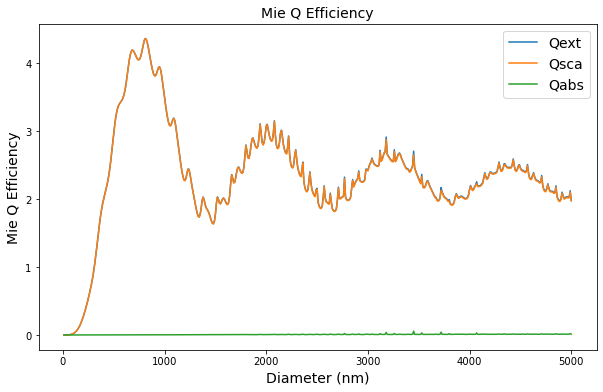

In [14]:
diameter = np.linspace(10, 5000, 500) # nm
m = 1.5 + 0.0001j # some absorption
wavelength = 589 # nm 

Qsca = np.zeros(len(diameter))
Qext = np.zeros(len(diameter))
Qabs = np.zeros(len(diameter))
ssa = np.zeros(len(diameter))
for Dp_i, Dp in enumerate(diameter):
    single_particle = ps.AutoMieQ(m, wavelength, Dp, asDict=True)
    Qsca[Dp_i] = single_particle['Qsca']
    Qext[Dp_i] = single_particle['Qext']
    Qabs[Dp_i] = single_particle['Qabs']
    ssa[Dp_i] = single_particle['Qsca']/single_particle['Qext']

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(diameter, Qext, label='Qext')
ax.plot(diameter, Qsca, label='Qsca')
ax.plot(diameter, Qabs, label='Qabs')
ax.set_xlabel('Diameter (nm)', fontsize=14)
ax.set_ylabel('Mie Q Efficiency', fontsize=14)
ax.legend(fontsize=14)
ax.set_title('Mie Q Efficiency', fontsize=14)


We can look at the net effect by plotting scattering / extinction. This is the single scattering albedo.

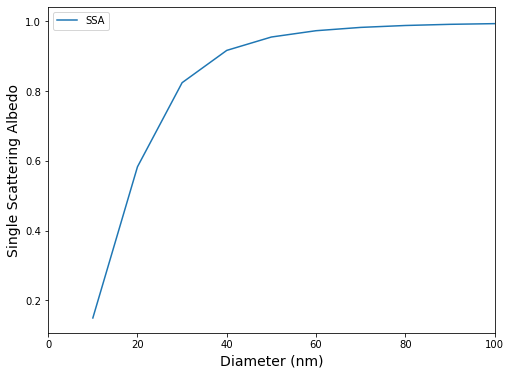

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(diameter, ssa, label='SSA')
ax.set_xlabel('Diameter (nm)', fontsize=14)
ax.set_ylabel('Single Scattering Albedo', fontsize=14)
ax.set_xlim(0, 100)
ax.legend()

Writing *for* loops is good for clarity, but we can let PyMieScatt do the work for us. Using `MieQ_withDiameterRange(m, wavelength, nMedium=1.0, diameterRange=(10,1000), nd=1000, logD=False)`
 https://pymiescatt.readthedocs.io/en/latest/forward.html#MieQ_withDiameterRange

The return will be a tuple of arrays. The first array is the diameter, then Mie efficiencies. We can plot this directly.

In [16]:
# https://pymiescatt.readthedocs.io/en/latest/forward.html#MieQ_withDiameterRange

m = 1.5 + 0.001j # some absorption
wavelength = 589 # nm
# tuple output order
# diameters, qext, qsca, qabs, g, qpr, qback, qratio 
simulation_low_abs = ps.MieQ_withDiameterRange(m, wavelength, diameterRange=(10, 10000), nd=500, logD=False)

m = 1.5 + 0.5j # some absorption
simulation_abs = ps.MieQ_withDiameterRange(m, wavelength, diameterRange=(10, 10000), nd=500, logD=False)

m = 2 + 0.5j # more real
simulation_scat = ps.MieQ_withDiameterRange(m, wavelength, diameterRange=(10, 10000), nd=500, logD=False)

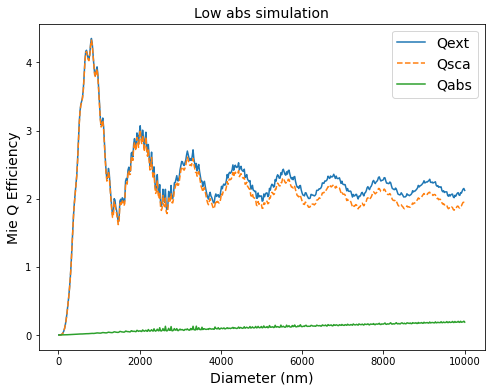

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(simulation_low_abs[0], simulation_low_abs[1], label='Qext')
ax.plot(simulation_low_abs[0], simulation_low_abs[2], label='Qsca', linestyle='dashed')
ax.plot(simulation_low_abs[0], simulation_low_abs[3], label='Qabs')
ax.set_xlabel('Diameter (nm)', fontsize = 14)
ax.set_ylabel('Mie Q Efficiency', fontsize = 14)
ax.set_title('Low abs simulation', fontsize = 14)
ax.legend(fontsize = 14)

Lets look at the comparison based on refractive index. 

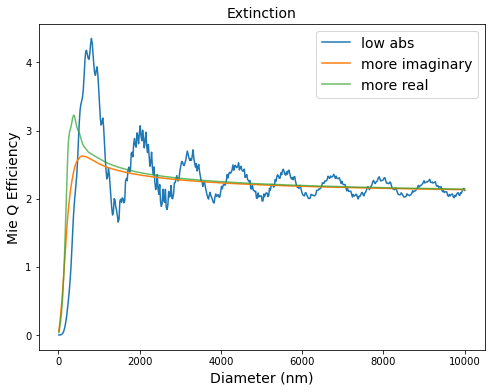

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(simulation_low_abs[0], simulation_low_abs[1], label='low abs')
ax.plot(simulation_abs[0], simulation_abs[1], label='more imaginary')
ax.plot(simulation_scat[0], simulation_scat[1], label='more real', alpha = 0.7) # alpha changes the transparency of the line 
ax.set_xlabel('Diameter (nm)', fontsize = 14)
ax.set_ylabel('Mie Q Efficiency', fontsize = 14)
ax.set_title('Extinction', fontsize = 14)
ax.legend(fontsize = 14)

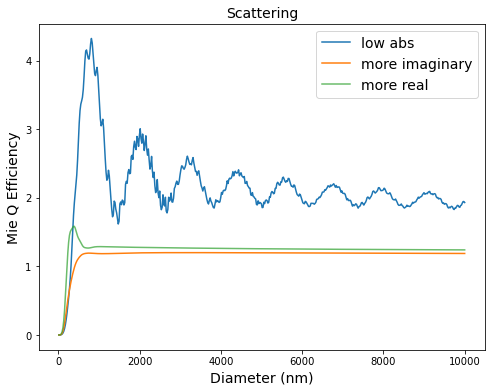

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(simulation_low_abs[0], simulation_low_abs[2], label='low abs')
ax.plot(simulation_abs[0], simulation_abs[2], label='more imaginary')
ax.plot(simulation_scat[0], simulation_scat[2], label='more real', alpha = 0.7) # alpha changes the transparency of the line 
ax.set_xlabel('Diameter (nm)', fontsize = 14)
ax.set_ylabel('Mie Q Efficiency', fontsize = 14)
ax.set_title('Scattering', fontsize = 14)
ax.legend(fontsize = 14)

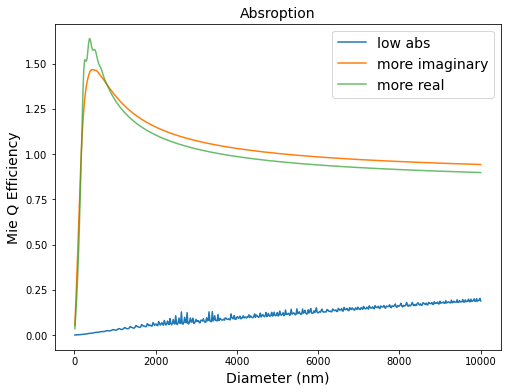

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(simulation_low_abs[0], simulation_low_abs[3], label='low abs')
ax.plot(simulation_abs[0], simulation_abs[3], label='more imaginary')
ax.plot(simulation_scat[0], simulation_scat[3], label='more real', alpha = 0.7) # alpha changes the transparency of the line 
ax.set_xlabel('Diameter (nm)', fontsize = 14)
ax.set_ylabel('Mie Q Efficiency', fontsize = 14)
ax.set_title('Absroption', fontsize = 14)
ax.legend( fontsize = 14)

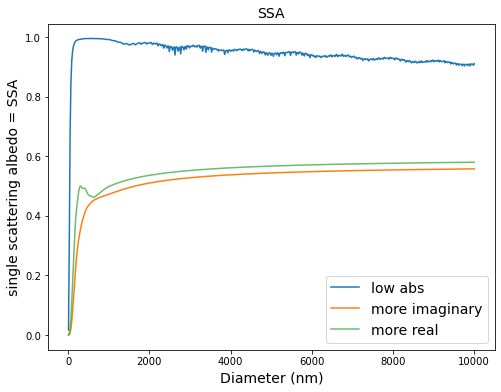

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(simulation_low_abs[0], simulation_low_abs[2]/simulation_low_abs[1], label='low abs')
ax.plot(simulation_abs[0], simulation_abs[2]/simulation_abs[1], label='more imaginary')
ax.plot(simulation_scat[0], simulation_scat[2]/simulation_scat[1], label='more real', alpha = 0.7) # alpha changes the transparency of the line 
ax.set_xlabel('Diameter (nm)', fontsize = 14)
ax.set_ylabel('single scattering albedo = SSA', fontsize = 14)
ax.set_title('SSA', fontsize = 14)
ax.legend(fontsize = 14)

## Constant diameter, vary wavelength.
Similar to before, we could just write a for loop...but I'll skip to the function that does the loop for us.

`MieQ_withWavelengthRange(m, diameter, nMedium=1.0, wavelengthRange=(100,1600), nw=1000, logW=False)`

https://pymiescatt.readthedocs.io/en/latest/forward.html#MieQ_withWavelengthRange

In [22]:
lambda_range  = (10, 1500)
diameter = 500 #nm 

m = 1.5 + 0.001j # some absorption 
simulation_low_abs = ps.MieQ_withWavelengthRange(m, diameter, nMedium=1.0, wavelengthRange=lambda_range, nw=500, logW=False)

m = 1.5 + 0.5j # more imaginary
simulation_abs = ps.MieQ_withWavelengthRange(m, diameter, nMedium=1.0, wavelengthRange=lambda_range, nw=500, logW=False)

m = 2 + 0.001j # more real
simulation_scat = ps.MieQ_withWavelengthRange(m, diameter, nMedium=1.0, wavelengthRange=lambda_range, nw=500, logW=False)

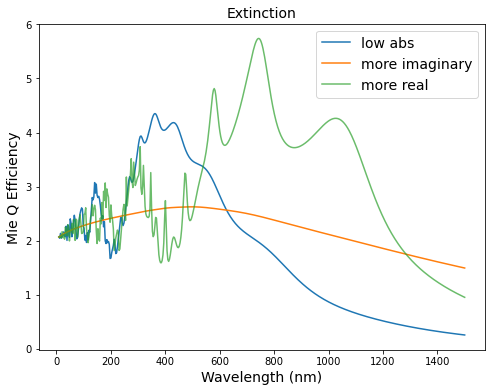

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(simulation_low_abs[0], simulation_low_abs[1], label='low abs')
ax.plot(simulation_abs[0], simulation_abs[1], label='more imaginary')
ax.plot(simulation_scat[0], simulation_scat[1], label='more real', alpha = 0.7) # alpha changes the transparency of the line 
ax.set_xlabel('Wavelength (nm)', fontsize = 14)
ax.set_ylabel('Mie Q Efficiency', fontsize = 14)
ax.set_title('Extinction', fontsize = 14)
ax.legend(fontsize = 14)

The Mie ressonance look a bit different on this scale.

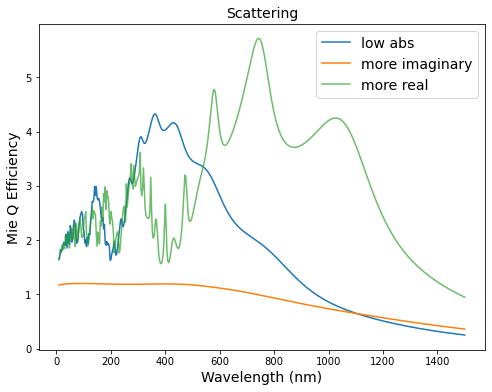

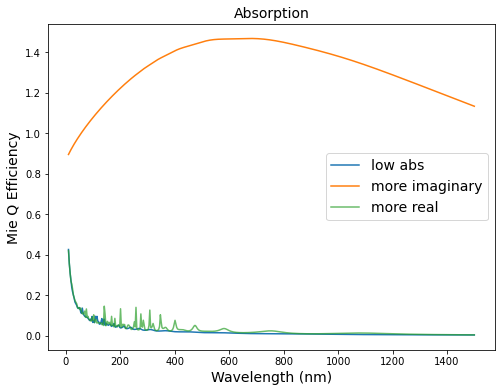

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(simulation_low_abs[0], simulation_low_abs[2], label='low abs')
ax.plot(simulation_abs[0], simulation_abs[2], label='more imaginary')
ax.plot(simulation_scat[0], simulation_scat[2], label='more real', alpha = 0.7) # alpha changes the transparency of the line 
ax.set_xlabel('Wavelength (nm)', fontsize = 14)
ax.set_ylabel('Mie Q Efficiency', fontsize = 14)
ax.set_title('Scattering', fontsize = 14)
ax.legend(fontsize = 14)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(simulation_low_abs[0], simulation_low_abs[3], label='low abs')
ax.plot(simulation_abs[0], simulation_abs[3], label='more imaginary')
ax.plot(simulation_scat[0], simulation_scat[3], label='more real', alpha = 0.7) # alpha changes the transparency of the line 
ax.set_xlabel('Wavelength (nm)', fontsize = 14)
ax.set_ylabel('Mie Q Efficiency', fontsize = 14)
ax.set_title('Absorption', fontsize = 14)
ax.legend(fontsize = 14)

On the above graphs:
* How does the peak depend on the particle size?
* How does the refractive index change the position the peak?
* What does the effect of absoprtion have on the resonances?

# Whispering Gallery Modes
Let's zoom in on those resonances. To find a interesting measurement tool. 

First we'll start with a large droplet relative to the wavelength and see what the Q ext looks like.

In [25]:
lambda_range  = (650, 700)
diameter = 10000 #nm 
m = 1.4 + 0.0001j # some absorption 

WGMs_dp1 = ps.MieQ_withWavelengthRange(m, diameter, nMedium=1.0, wavelengthRange=lambda_range, nw=2000, logW=False)

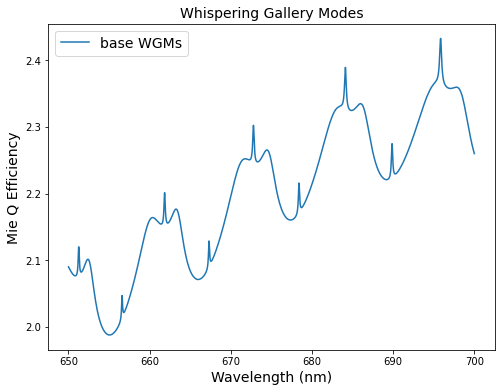

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(WGMs_dp1[0], WGMs_dp1[1], label='base WGMs')
ax.set_xlabel('Wavelength (nm)', fontsize = 14)
ax.set_ylabel('Mie Q Efficiency', fontsize = 14)
ax.set_title('Whispering Gallery Modes', fontsize = 14)
ax.legend( fontsize = 14)

All right, now lets change the size of the droplet a little.

In [27]:
size_delta = 10
WGMs_plus = ps.MieQ_withWavelengthRange(m, diameter+size_delta, nMedium=1.0, wavelengthRange=lambda_range, nw=2000, logW=False)
WGMs_minus = ps.MieQ_withWavelengthRange(m, diameter-size_delta, nMedium=1.0, wavelengthRange=lambda_range, nw=2000, logW=False)

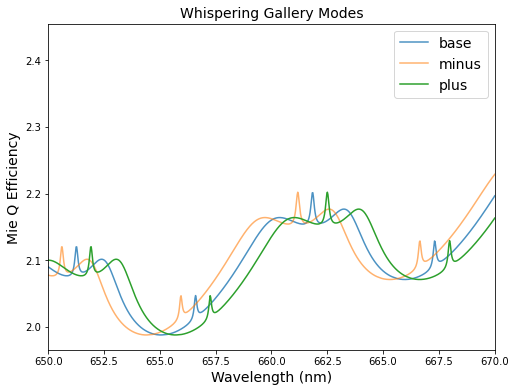

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(WGMs_dp1[0], WGMs_dp1[1], label='base', alpha = 0.8)
ax.plot(WGMs_minus[0], WGMs_minus[1], label='minus', alpha = 0.6)
ax.plot(WGMs_plus[0], WGMs_plus[1], label='plus')
ax.set_xlabel('Wavelength (nm)', fontsize = 14)
ax.set_ylabel('Mie Q Efficiency', fontsize = 14)
ax.set_title('Whispering Gallery Modes', fontsize = 14)
ax.set_xlim(650, 670)
# ax.set_xlim(667, 668)
ax.legend(fontsize = 14)

So we got a noticable change in the resonance position. 10 nm on a 10000 nm droplet is a 0.1% change, quite impressive measurement sensitivity.

We can rerun the above code and zoom in on a resonance.
* What is happening here? Why is the resonance position changing?
* Is this a real effect? What is the physical reason for this?
* What might the size limitations be for this measurement?

## Distribution of particles

For a collections of particles, as long as the multiple scattering is small, we can use the Mie theory to calculate the scattering of the collection. Each particles scattering and absorption is added together.

$$ b_{Mie} = \frac{\pi D_p^2}{4} ~ Q_{Mie} ~ N_{number}$$
The optical depth 
$$ \tau =  b_{Mie} z_{path~length}$$

First we'll need a distribution of particles. This can be normal, but lognormal is more typical in the atmosphere.

Text(0.5, 1.0, 'Particle Counts')

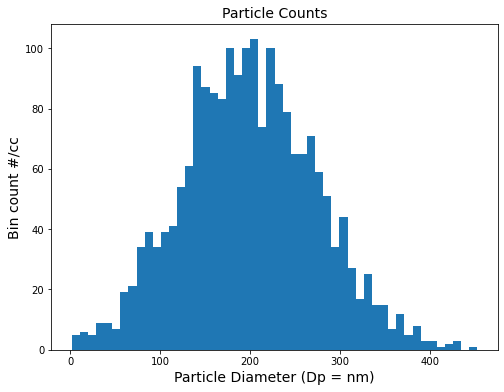

In [29]:

mu, sigma = 200, 75 # mean and standard deviation
s = np.random.normal(mu, sigma, 2000)
s = np.abs(s)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
count, bins, ignored = plt.hist(s, 50)
ax.set_xlabel('Particle Diameter (Dp = nm)', fontsize = 14)
ax.set_ylabel('Bin count #/cc', fontsize = 14)
ax.set_title('Particle Counts', fontsize = 14)

Ok, lets calculate the Qext for each particle and calculate Bext from the size and number in that bin.

Text(0.5, 1.0, 'Extinction coefficient')

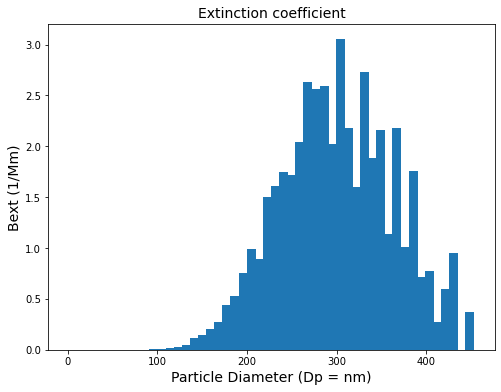

In [30]:
ndp = count
diameter = bins[:-1]+np.diff(bins)/2
m = 1.5 + 0.001j # some absorption
wavelength = 589 #nm


Qext_manual = np.zeros(len(diameter))
for Dp_i, Dp in enumerate(diameter):
    single_particle = ps.AutoMieQ(m, wavelength, Dp, asDict=True)
    Qext_manual[Dp_i] = single_particle['Qext']
    

# scaling of 1e-6 to cast in units of inverse megameters - see docs
aSDn = np.pi*((diameter/2)**2)*ndp*(1e-6)
Bext_dp = Qext_manual*aSDn

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.bar(diameter, Bext_dp, width=10)
ax.set_xlabel('Particle Diameter (Dp = nm)', fontsize = 14)
ax.set_ylabel('Bext (1/Mm)', fontsize = 14)
ax.set_title('Extinction coefficient', fontsize = 14)

We can get the total Bext from the sum of the Bext for each bin.

In [31]:
Bext = np.sum(Qext_manual*aSDn)

print('Total Extinction Coefficient = ', Bext)

Total Extinction Coefficient =  46.281947548239735


The Bext graph looked a little shifted from the size distribution, lets compare the two.

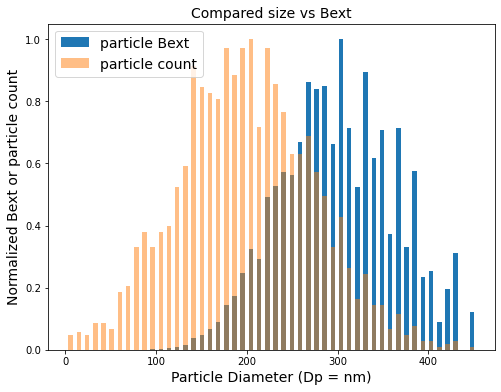

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.bar(diameter, Bext_dp/Bext_dp.max(), width=5, label='particle Bext')
ax.bar(diameter, ndp/ndp.max(), width=5, alpha=0.5, label='particle count')

ax.set_xlabel('Particle Diameter (Dp = nm)', fontsize = 14)
ax.set_ylabel('Normalized Bext or particle count', fontsize = 14)
ax.set_title('Compared size vs Bext', fontsize = 14)
ax.legend(fontsize = 14)

* What is happening here?
* Why is the max of the Bext not at the peak of the size distribution?

Instead of using the for loop manually, we can use the `Mie_SD` function. 

`Mie_SD(m, wavelength, dp, ndp, nMedium=1.0, SMPS=True, interpolate=False, asDict=False)`

https://pymiescatt.readthedocs.io/en/latest/forward.html#Mie_SD


In [33]:
B_built_in = ps.Mie_SD(m, wavelength, diameter, ndp, SMPS=True, asDict=True) # this needs pymiescat v 1.8.1
print(json.dumps(B_built_in, indent=4))

print('Manual Bext = ', Bext)

{
    "Bext": 46.281947548239735,
    "Bsca": 45.93746176243862,
    "Babs": 0.3444857858011119,
    "G": 0.504261229085751,
    "Bpr": 23.117466618832747,
    "Bback": 12.026431590415154,
    "Bratio": 34.71275599172814
}
Manual Bext =  46.281947548239735


We can see compare the manual method and the `Mie_SD` function, and they give the same results.

Now lets look at a Lognormal distribution.

Text(0.5, 1.0, 'Whispering Gallery Modes')

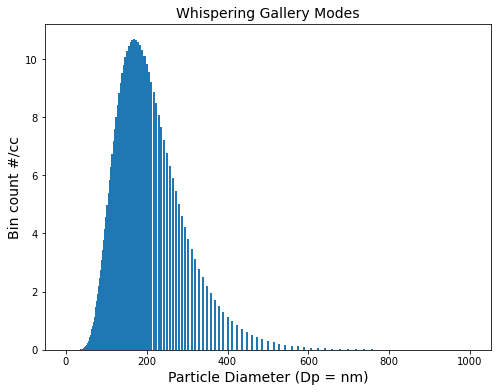

In [34]:
m = 1.5 + 0.001j # some absorption
wavelength = 589 #nm

mu = 200
sigma = 1.5
total_count = 2000

Bext, Bsca, Babs, bigG, Bpr, Bback, Bratio, dp, ndp, = ps.Mie_Lognormal(m, wavelength, geoStdDev=sigma, geoMean=mu, numberOfParticles=total_count, numberOfBins=250, upper=1000, returnDistribution=True)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.bar(dp, ndp, label='particle count', width = 5)
ax.set_xlabel('Particle Diameter (Dp = nm)', fontsize = 14)
ax.set_ylabel('Bin count #/cc', fontsize = 14)
ax.set_title('Whispering Gallery Modes', fontsize = 14)

Now with the lognormal distribution, lets do a wavelength scan, like we did before for a single particle.

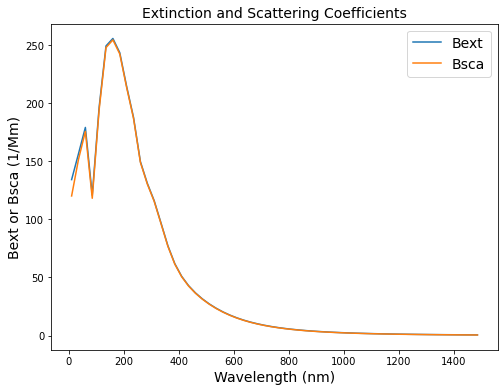

In [35]:
m = 1.5 + 0.001j # some absorption

mu = 200
sigma = 1.02
total_count = 2000

wavelength_vector = np.arange(10, 1500, 25)


Bext_vector = np.zeros(len(wavelength_vector))
Bsca_vector = np.zeros(len(wavelength_vector))

for i, wavelength in enumerate(wavelength_vector):
    Bext_vector[i], Bsca_vector[i], _, _, _, _, _, = ps.Mie_Lognormal(m, wavelength, geoStdDev=sigma, geoMean=mu, numberOfParticles=total_count, numberOfBins=250, upper=1000, returnDistribution=False)


fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(wavelength_vector, Bext_vector, label='Bext')
ax.plot(wavelength_vector, Bsca_vector, label='Bsca')
ax.set_xlabel('Wavelength (nm)', fontsize = 14)
ax.set_ylabel('Bext or Bsca (1/Mm)', fontsize = 14)
ax.set_title('Extinction and Scattering Coefficients', fontsize = 14)
ax.legend(fontsize = 14)

What happened to our Mie resonances?

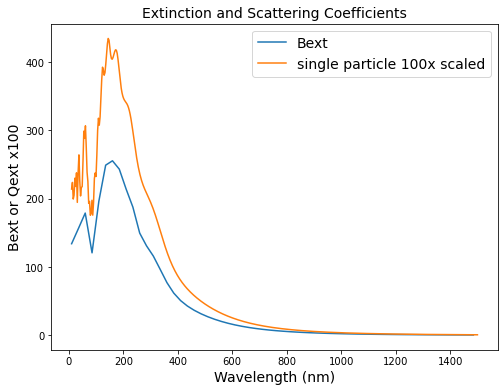

In [36]:
lambda_range  = (10, 1500)
diameter = mu #nm 

simulation_low_abs = ps.MieQ_withWavelengthRange(m, diameter, nMedium=1.0, wavelengthRange=lambda_range, nw=500, logW=False)


fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(wavelength_vector, Bext_vector, label='Bext')
ax.plot(simulation_low_abs[0], simulation_low_abs[1]*100, label='single particle 100x scaled')
ax.set_xlabel('Wavelength (nm)', fontsize = 14)
ax.set_ylabel('Bext or Qext x100', fontsize = 14)
ax.set_title('Extinction and Scattering Coefficients', fontsize = 14)
ax.legend(fontsize = 14)

* What is the limiting case to get the resonances back?
* Size?
* Sigma of the lognormal distribution?
* Refractive index?

## Fixed wavelength, vary the mean of the lognormal distribution.
Let's look at the size effect on the Mie resonances.

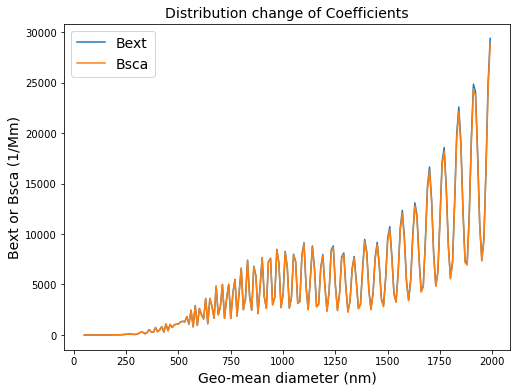

In [37]:
m = 1.5 + 0.001j # some absorption
wavelength = 589 #nm

sigma = 1.01
total_count = 2000

diameter = np.arange(50, 2000, 10)


Bext_vector = np.zeros(len(diameter))
Bsca_vector = np.zeros(len(diameter))

for i, mu in enumerate(diameter):
    Bext_vector[i], Bsca_vector[i], _, _, _, _, _, = ps.Mie_Lognormal(m, wavelength, geoStdDev=sigma, geoMean=mu, numberOfParticles=total_count, numberOfBins=250, upper=20000, returnDistribution=False)


fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(diameter, Bext_vector, label='Bext')
ax.plot(diameter, Bsca_vector, label='Bsca')
ax.set_xlabel('Geo-mean diameter (nm)', fontsize = 14)
ax.set_ylabel('Bext or Bsca (1/Mm)', fontsize = 14)
ax.set_title('Distribution change of Coefficients', fontsize = 14)
ax.legend(fontsize = 14)

What could be the limiting case to get the resonances back?
* Size?
* Sigma of the lognormal distribution?
* Refractive index?

# Rayleigh to Mie Scattering Phase Function

We can use the `ScatteringFunction` function to calculate the phase function for a single particle.

`ScatteringFunction(m, wavelength, diameter, nMedium=1.0, minAngle=0, maxAngle=180, angularResolution=0.5, space='theta', angleMeasure='radians', normalization=None)`

http://pymiescatt.readthedocs.io/en/latest/forward.html#ScatteringFunction

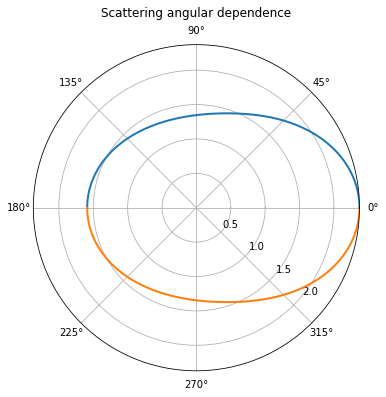

In [55]:
m = 5 + 0.0001j # some absorption
wavelength = 589 #nm
dp = 250 #nm.


theta,SL,SR,SU = ps.ScatteringFunction(m,wavelength,dp)


fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6))
ax.plot(theta, SU, label='unplolarized', linewidth=2)
ax.plot(theta+np.pi, np.flip(SU), label='unplolarized', linewidth=2)
ax.set_rmax(np.max(SU))
ax.set_rlabel_position(-40)  # Move radial labels away from plotted line
ax.grid(True)
ax.set_title("Scattering angular dependence", va='bottom')
plt.show()

* What would be the Rayleigh phase function?
* How about the result for a cloud droplet?
* How does the refractive index change the phase function? 
* More absorption?

# Core - Shell particles

What about particles with a coating? We can use the `MieQCoreShell` function to calculate the scattering properties of a core-shell particle.

Why would this change the optical properties of the particle?

In [58]:
m_core = 1.6 + 0.5j # some absorption
m_shell = 1.45 + 0.001j # some absorption

wavelength = 589 #nm
dp_shell = 200 # total particle diameter
dp_core = 150 #nm.

particle_core_shell = ps.MieQCoreShell(m_core, m_shell, wavelength, dp_core, dp_shell, asDict=True)
print('core_shell only Qext ', particle_core_shell['Qext'])

particle_shell = ps.MieQ(m_shell, wavelength, dp_shell, asDict=True)
particle_shell_core_to_remove = ps.MieQ(m_shell, wavelength, dp_core, asDict=True)
particle_shell_Qext_minus_core = particle_shell['Qext'] - particle_shell_core_to_remove['Qext']
print('shell Qext ', particle_shell['Qext'])
print('shell Qext minus core approx.', particle_shell_Qext_minus_core)

core_shell only Qext  0.9149961350235847
shell Qext  0.2215259344662242
shell Qext minus core approx. 0.14290513257440676


Lets do some calculations, to see if the scattering properties are additive.

In [59]:
particle_core = ps.MieQ(m_core, wavelength, dp_core, asDict=True)
print('core only Qext ', particle_core['Qext'])
print('shell only Qext ', particle_shell_Qext_minus_core)

print('')
print('core + shell Qext ', particle_core['Qext'] + particle_shell_Qext_minus_core)
print('core_shell Qext ', particle_core_shell['Qext'])

core only Qext  1.0848206402387346
shell only Qext  0.14290513257440676

core + shell Qext  1.2277257728131414
core_shell Qext  0.9149961350235847


* When is the sum more than the parts?
* When is it less than the parts?

Text(0.5, 1.0, 'Extinction coefficient')

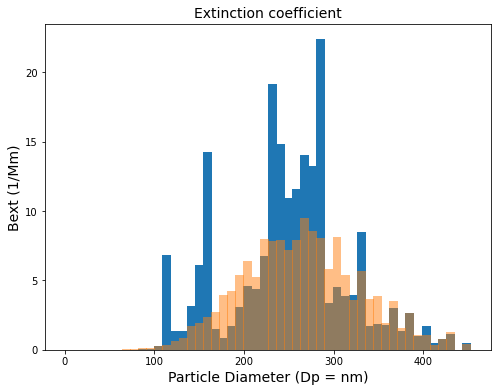

In [64]:
ndp = count
diameter = bins[:-1]+np.diff(bins)/2
m_core = 1.6 + 0.5j # some absorption
m_shell = 1.45 + 0.001j # some absorption

wavelength = 589 #nm
dp_shell = 200 # total particle diameter
dp_core = 150 #nm.


Qext_manual = np.zeros(len(diameter))
Qext_core_shell = np.zeros(len(diameter))

for Dp_i, Dp in enumerate(diameter):
    single_particle = ps.AutoMieQ(m, wavelength, Dp, asDict=True)
    Qext_manual[Dp_i] = single_particle['Qext']

    particle_core_shell = ps.MieQCoreShell(m_core, m_shell, wavelength, Dp, Dp+20, asDict=True)
    Qext_core_shell[Dp_i] = particle_core_shell['Qext']

    

# scaling of 1e-6 to cast in units of inverse megameters - see docs
aSDn = np.pi*((diameter/2)**2)*ndp*(1e-6)
Bext_dp = Qext_manual*aSDn
aSDn = np.pi*(((diameter+20)/2)**2)*ndp*(1e-6)
Bext_dp_core_shell = Qext_core_shell*aSDn


fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.bar(diameter, Bext_dp, width=10)
ax.bar(diameter, Bext_dp_core_shell, width=10, alpha=0.5)

ax.set_xlabel('Particle Diameter (Dp = nm)', fontsize = 14)
ax.set_ylabel('Bext (1/Mm)', fontsize = 14)
ax.set_title('Extinction coefficient', fontsize = 14)